# Quantized Linear Regression

Currently, **concrete** only supports unsigned integers up to 7-bits. Nevertheless, we want to evaluate a linear regression model with it. Luckily, we can make use of **quantization** to overcome this limitation!

### Let's start by importing some libraries to develop our linear regression model

In [1]:
import numpy as np

### And some helpers for visualization

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### We need an inputset, a handcrafted one for simplicity

In [3]:
x = np.array([[130], [110], [100], [145], [160], [185], [200], [80], [50]], dtype=np.float32)
y = np.array([325, 295, 268, 400, 420, 500, 520, 220, 120], dtype=np.float32)

### Let's visualize our inputset to get a grasp of it

In [4]:
plt.ioff()
fig, ax = plt.subplots(1)

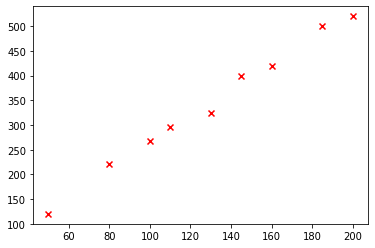

In [5]:
ax.scatter(x[:, 0], y, marker="x", color="red")
display(fig)

### Now, we need a model so let's define it

The main purpose of this tutorial is not to train a linear regression model but to use it homomorphically. So we will not discuss about how the model is trained.

In [6]:
class Model:
    w = None
    b = None

    def fit(self, x, y):
        a = np.ones((x.shape[0], x.shape[1] + 1), dtype=np.float32)
        a[:, 1:] = x

        regularization_contribution = np.identity(x.shape[1] + 1, dtype=np.float32)
        regularization_contribution[0][0] = 0

        parameters = np.linalg.pinv(a.T @ a + regularization_contribution) @ a.T @ y

        self.b = parameters[0]
        self.w = parameters[1:].reshape(-1, 1)

        return self

    def evaluate(self, x):
        return x @ self.w + self.b

### And create one

In [7]:
model = Model().fit(x, y)

### Time to make some predictions

In [8]:
inputs = np.linspace(40, 210, 100).reshape(-1, 1)
predictions = model.evaluate(inputs)

### Let's visualize our predictions to see how our model performs

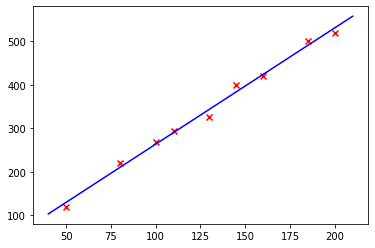

In [9]:
ax.plot(inputs, predictions, color="blue")
display(fig)

### As a bonus let's inspect the model parameters

In [10]:
print(model.w)
print(model.b)

[[2.669915]]
-3.2335143


They are floating point numbers and we can't directly work with them!

### So, let's abstract quantization

Here is a quick summary of quantization. We have a range of values and we want to represent them using small number of bits (n). To do this, we split the range into 2^n sections and map each section to a value. Here is a visualization of the process!

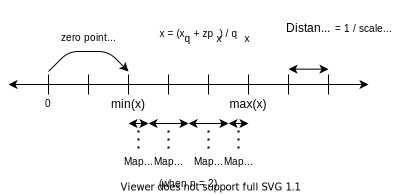

In [11]:
from IPython.display import SVG
SVG(filename="figures/QuantizationVisualized.svg")

If you want to learn more, head to https://intellabs.github.io/distiller/algo_quantization.html

In [12]:
class QuantizationParameters:
    def __init__(self, q, zp, n):
        # q = scale factor = 1 / distance between consecutive values
        # zp = zero point which is used to determine the beginning of the quantized range
        #     (quantized 0 = the beginning of the quantized range = zp * distance between consecutive values)
        # n = number of bits
        
        # e.g.,
        
        # n = 2
        # zp = 2
        # q = 0.66
        # distance between consecutive values = 1 / q = 1.5151
        
        # quantized 0 = zp / q = zp * distance between consecutive values = 3.0303
        # quantized 1 = quantized 0 + distance between consecutive values = 4.5454
        # quantized 2 = quantized 1 + distance between consecutive values = 6.0606
        # quantized 3 = quantized 2 + distance between consecutive values = 7.5757
        
        self.q = q
        self.zp = zp
        self.n = n

class QuantizedArray:
    def __init__(self, values, parameters):
        # values = quantized values
        # parameters = parameters used during quantization
        
        # e.g.,
        
        # values = [1, 0, 2, 1]
        # parameters = QuantizationParameters(q=0.66, zp=2, n=2)
        
        # original array = [4.5454, 3.0303, 6.0606, 4.5454]
        
        self.values = np.array(values)
        self.parameters = parameters

    @staticmethod
    def of(x, n):
        if not isinstance(x, np.ndarray):
            x = np.array(x)

        min_x = x.min()
        max_x = x.max()

        if min_x == max_x: # encoding single valued arrays
            
            if min_x == 0.0: # encoding 0s
                
                # dequantization = (x_q + zp_x) / q_x = 0 --> q_x = 1 && zp_x = 0 && x_q = 0
                q_x = 1
                zp_x = 0
                x_q = np.zeros(x.shape, dtype=np.uint)
                
            elif min_x < 0.0: # encoding negative scalars
                
                # dequantization = (x_q + zp_x) / q_x = -x --> q_x = 1 / x & zp_x = -1 & x_q = 0
                q_x = abs(1 / min_x)
                zp_x = -1
                x_q = np.zeros(x.shape, dtype=np.uint)
                
            else: # encoding positive scalars
                
                # dequantization = (x_q + zp_x) / q_x = x --> q_x = 1 / x & zp_x = 0 & x_q = 1
                q_x = 1 / min_x
                zp_x = 0
                x_q = np.ones(x.shape, dtype=np.uint)
                
        else: # encoding multi valued arrays
            
            # distance between consecutive values = range of x / number of different quantized values = (max_x - min_x) / (2^n - 1)
            # q = 1 / distance between consecutive values
            q_x = (2**n - 1) / (max_x - min_x)
            
            # zp = what should be added to 0 to get min_x -> min_x = (0 + zp) / q -> zp = min_x * q
            zp_x = int(round(min_x * q_x))
            
            # x = (x_q + zp) / q -> x_q = (x * q) - zp
            x_q = ((q_x * x) - zp_x).round().astype(np.uint)

        return QuantizedArray(x_q, QuantizationParameters(q_x, zp_x, n))

    def dequantize(self):
        # x = (x_q + zp) / q
        # x = (x_q + zp) / q
        return (self.values.astype(np.float32) + float(self.parameters.zp)) / self.parameters.q

    def affine(self, w, b, min_y, max_y, n_y):
        # the formulas used in this method was derived from the following equations
        #
        # x = (x_q + zp_x) / q_x
        # w = (w_q + zp_w) / q_w
        # b = (b_q + zp_b) / q_b
        #
        # (x * w) + b = ((x_q + zp_x) / q_x) * ((w_q + zp_w) / q_w) + ((b_q + zp_b) / q_b)
        #             = y = (y_q + zp_y) / q_y
        #
        # So, ((x_q + zp_x) / q_x) * ((w_q + zp_w) / q_w) + ((b_q + zp_b) / q_b) = (y_q + zp_y) / q_y
        # We can calculate zp_y and q_y from min_y, max_y, n_y. So, the only unknown is y_q and it can be solved.

        x_q = self.values
        w_q = w.values
        b_q = b.values

        q_x = self.parameters.q
        q_w = w.parameters.q
        q_b = b.parameters.q

        zp_x = self.parameters.zp
        zp_w = w.parameters.zp
        zp_b = b.parameters.zp

        q_y = (2**n_y - 1) / (max_y - min_y)
        zp_y = int(round(min_y * q_y))

        y_q = (q_y / (q_x * q_w)) * ((x_q + zp_x) @ (w_q + zp_w) + (q_x * q_w / q_b) * (b_q + zp_b))
        y_q -= min_y * q_y
        y_q = y_q.round().clip(0, 2**n_y - 1).astype(np.uint)

        return QuantizedArray(y_q, QuantizationParameters(q_y, zp_y, n_y))

class QuantizedFunction:
    def __init__(self, table):
        self.table = table

    @staticmethod
    def of(f, input_bits, output_bits):
        domain = np.array(range(2**input_bits), dtype=np.uint)
        table = f(domain).round().clip(0, 2**output_bits - 1).astype(np.uint)
        return QuantizedFunction(table)

### Let's quantize our model parameters

Since the parameters only consist of scalars, we can use a single bit quantization.

In [13]:
parameter_bits = 1

w_q = QuantizedArray.of(model.w, parameter_bits)
b_q = QuantizedArray.of(model.b, parameter_bits)

### And quantize our inputs

In [14]:
input_bits = 6

x_q = QuantizedArray.of(inputs, input_bits)

### Time to make quantized inference

In [15]:
output_bits = 7

min_y = predictions.min()
max_y = predictions.max()
y_q = x_q.affine(w_q, b_q, min_y, max_y, output_bits)

quantized_predictions = y_q.dequantize()

### And visualize the results

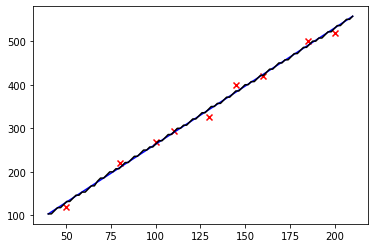

In [16]:
ax.plot(inputs, quantized_predictions, color="black")
display(fig)

### Now it's time to make the inference homomorphic

In [17]:
q_y = (2**output_bits - 1) / (max_y - min_y)
zp_y = int(round(min_y * q_y))

q_x = x_q.parameters.q
q_w = w_q.parameters.q
q_b = b_q.parameters.q

zp_x = x_q.parameters.zp
zp_w = w_q.parameters.zp
zp_b = b_q.parameters.zp

x_q = x_q.values
w_q = w_q.values
b_q = b_q.values

### Simplification to rescue!

The `y_q` formula in `QuantizedArray.affine(...)` can be rewritten to make it easier to implement in homomorphically. Here is the breakdown.
```
(q_y / (q_x * q_w)) * ((x_q + zp_x) @ (w_q + zp_w) + (q_x * q_w / q_b) * (b_q + zp_b)) - (min_y * q_y)
^^^^^^^^^^^^^^^^^^^    ^^^^^^^^^^^^   ^^^^^^^^^^^^   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^    ^^^^^^^^^^^^^
constant (c1)          can be done    constant (c2)  constant (c3)                       constant (c4)
                       on the circuit  
                       
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^
                       can be done on the circuit
                       
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
cannot be done on the circuit because of floating point operation so will be a single table lookup
```

### Let's import the concrete numpy package now!

In [18]:
import concrete.numpy as hnp

In [19]:
c1 = q_y / (q_x * q_w)
c2 = w_q + zp_w
c3 = (q_x * q_w / q_b) * (b_q + zp_b)
c4 = min_y * q_y

f = lambda intermediate: (c1 * (intermediate + c3)) - c4
f_q = QuantizedFunction.of(f, input_bits + parameter_bits, output_bits)

table = hnp.LookupTable([int(entry) for entry in f_q.table])

w_0 = int(c2.flatten()[0])

def infer(x_0):
    return table[(x_0 + zp_x) * w_0]

### Let's compile our quantized inference function to it's operation graph for visualization

In [20]:
inputset = []
for x_i in x_q:
    inputset.append((int(x_i[0]),))

homomorphic_model = hnp.compile_numpy_function_into_op_graph(
    infer,
    {"x_0": hnp.EncryptedScalar(hnp.Integer(input_bits, is_signed=False))},
    inputset,
)

### Here are some representations of the operation graph

In [21]:
print(hnp.get_printable_graph(homomorphic_model, show_data_types=True))

%0 = Constant(1)                         # ClearScalar<Integer<unsigned, 8 bits>>
%1 = x_0                                 # EncryptedScalar<Integer<unsigned, 7 bits>>
%2 = Constant(15)                        # ClearScalar<Integer<unsigned, 8 bits>>
%3 = Add(1, 2)                           # EncryptedScalar<Integer<unsigned, 7 bits>>
%4 = Mul(3, 0)                           # EncryptedScalar<Integer<unsigned, 7 bits>>
%5 = TLU(4)                              # EncryptedScalar<Integer<unsigned, 7 bits>>
return(%5)



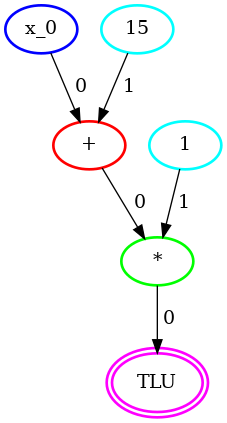

In [22]:
hnp.draw_graph(homomorphic_model).show()

### It's time to compile the function to its homomorphic equivalent

In [23]:
engine = hnp.compile_numpy_function(
    infer,
    {"x_0": hnp.EncryptedScalar(hnp.Integer(input_bits, is_signed=False))},
    inputset,
)

### Finally, let's make homomorphic inference

In [24]:
homomorphic_predictions = []
for x_i in map(lambda x_i: int(x_i[0]), x_q):
    inference = QuantizedArray(engine.run(x_i), y_q.parameters)
    homomorphic_predictions.append(inference.dequantize())
homomorphic_predictions = np.array(homomorphic_predictions, dtype=np.float32)

### And visualize it

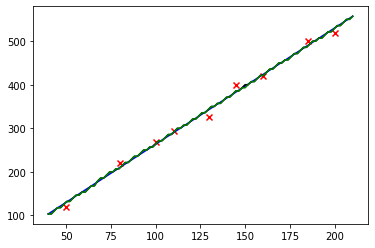

In [25]:
ax.plot(inputs, homomorphic_predictions, color="green")
display(fig)

### Enjoy!